In [1]:
# Import necessary libaries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from requests import get

In [2]:
# Make a request
url = 'https://covid19.ncdc.gov.ng'
response = get(url, headers = {"Accept-Language": "en-US, en;q=0.5"})

In [3]:
print(response.text[:500])

<!DOCTYPE html>
<html lang="en">
<meta http-equiv="content-type" content="text/html;charset=UTF-8" />
<head>
<title>NCDC Coronavirus COVID-19 Microsite</title>
<!--[if lt IE 11]>
    	<script src="https://oss.maxcdn.com/libs/html5shiv/3.7.0/html5shiv.js"></script>
    	<script src="https://oss.maxcdn.com/libs/respond.js/1.4.2/respond.min.js"></script>
    	<![endif]-->
<meta charset="utf-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0, user-scalable=0, minimal-ui">
<meta


In [4]:
# Create a beautifulsoup object
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [5]:
# Locate table
covid_table = html_soup.find('div', class_ = 'table-responsive')

In [6]:
# Scrape table headers and pass into a list
table_heading = covid_table.thead.find_all('th')
headings = []
for th in table_heading:
    headings.append(th.text)
print(headings)

['States Affected', 'No. of Cases (Lab Confirmed)', 'No. of Cases (on admission)', 'No. Discharged', 'No. of Deaths']


In [7]:
# Scrape table rows and pass into a list
table_rows = []
for i in covid_table.tbody.find_all('tr'):
    table_rows.append(i.text.replace('\n', ' ').strip())
table_rows

['Lagos  6,065  5,049  944  72',
 'Kano  1,020  473  497  50',
 'FCT  1,012  713  275  24',
 'Ogun  471  272  186  13',
 'Edo  462  322  115  25',
 'Katsina  399  169  209  21',
 'Oyo  398  279  112  7',
 'Rivers  394  215  158  21',
 'Kaduna  369  129  230  10',
 'Borno  367  136  205  26',
 'Bauchi  364  131  224  9',
 'Jigawa  309  148  156  5',
 'Gombe  246  101  135  10',
 'Delta  175  117  50  8',
 'Ebonyi  152  85  67  0',
 'Kwara  143   79  63  1',
 'Sokoto  129  14  101  14',
 'Plateau  128  26  99  3',
 'Nasarawa  113  77  31  5',
 'Abia  97  90  7  0',
 'Imo  83  64  19  0',
 'Zamfara  76   0  71  5',
 'Yobe  52  20  25  7',
 'Osun  50  7  39  4',
 'Anambra  46  42  3  1',
 'Ondo  46  18  21  7',
 'Niger  46  19  26  1',
 'Akwa Ibom  45   28  15  2',
 'Adamawa  42  4  34  4',
 'Kebbi  41  8  29  4',
 'Enugu  30  15  14  1',
 'Ekiti  30  10  18  2',
 'Bayelsa  30  10  17  3',
 'Taraba  18   8  10  0',
 'Benue  13  12  1  0',
 'Kogi  3  3  0  0']

In [8]:
# Format table rows for dataframe
table_rows = [i.split() for i in table_rows]
table_rows

[['Lagos', '6,065', '5,049', '944', '72'],
 ['Kano', '1,020', '473', '497', '50'],
 ['FCT', '1,012', '713', '275', '24'],
 ['Ogun', '471', '272', '186', '13'],
 ['Edo', '462', '322', '115', '25'],
 ['Katsina', '399', '169', '209', '21'],
 ['Oyo', '398', '279', '112', '7'],
 ['Rivers', '394', '215', '158', '21'],
 ['Kaduna', '369', '129', '230', '10'],
 ['Borno', '367', '136', '205', '26'],
 ['Bauchi', '364', '131', '224', '9'],
 ['Jigawa', '309', '148', '156', '5'],
 ['Gombe', '246', '101', '135', '10'],
 ['Delta', '175', '117', '50', '8'],
 ['Ebonyi', '152', '85', '67', '0'],
 ['Kwara', '143', '79', '63', '1'],
 ['Sokoto', '129', '14', '101', '14'],
 ['Plateau', '128', '26', '99', '3'],
 ['Nasarawa', '113', '77', '31', '5'],
 ['Abia', '97', '90', '7', '0'],
 ['Imo', '83', '64', '19', '0'],
 ['Zamfara', '76', '0', '71', '5'],
 ['Yobe', '52', '20', '25', '7'],
 ['Osun', '50', '7', '39', '4'],
 ['Anambra', '46', '42', '3', '1'],
 ['Ondo', '46', '18', '21', '7'],
 ['Niger', '46', '19', '2

In [9]:
# Join 'Akwa' and 'Ibom'
del table_rows[27][1]
table_rows[27][0] = 'Akwa Ibom'
table_rows

[['Lagos', '6,065', '5,049', '944', '72'],
 ['Kano', '1,020', '473', '497', '50'],
 ['FCT', '1,012', '713', '275', '24'],
 ['Ogun', '471', '272', '186', '13'],
 ['Edo', '462', '322', '115', '25'],
 ['Katsina', '399', '169', '209', '21'],
 ['Oyo', '398', '279', '112', '7'],
 ['Rivers', '394', '215', '158', '21'],
 ['Kaduna', '369', '129', '230', '10'],
 ['Borno', '367', '136', '205', '26'],
 ['Bauchi', '364', '131', '224', '9'],
 ['Jigawa', '309', '148', '156', '5'],
 ['Gombe', '246', '101', '135', '10'],
 ['Delta', '175', '117', '50', '8'],
 ['Ebonyi', '152', '85', '67', '0'],
 ['Kwara', '143', '79', '63', '1'],
 ['Sokoto', '129', '14', '101', '14'],
 ['Plateau', '128', '26', '99', '3'],
 ['Nasarawa', '113', '77', '31', '5'],
 ['Abia', '97', '90', '7', '0'],
 ['Imo', '83', '64', '19', '0'],
 ['Zamfara', '76', '0', '71', '5'],
 ['Yobe', '52', '20', '25', '7'],
 ['Osun', '50', '7', '39', '4'],
 ['Anambra', '46', '42', '3', '1'],
 ['Ondo', '46', '18', '21', '7'],
 ['Niger', '46', '19', '2

In [10]:
# Pass table rows into data frame
data = pd.DataFrame(table_rows)
data.head()

,0,1,2,3,4
0,Lagos,"6,065","5,049",944,72
1,Kano,"1,020",473,497,50
2,FCT,"1,012",713,275,24
3,Ogun,471,272,186,13
4,Edo,462,322,115,25


In [11]:
# Set table headers from headings list
data.columns = headings
data.head()

,States Affected,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths
0,Lagos,"6,065","5,049",944,72
1,Kano,"1,020",473,497,50
2,FCT,"1,012",713,275,24
3,Ogun,471,272,186,13
4,Edo,462,322,115,25


In [12]:
# Remove all commas from columns
data.replace(',','', regex=True, inplace=True)

In [13]:
col = data.select_dtypes(object).columns[1:]
data[col] = data[col].apply(pd.to_numeric, errors='coerce')

In [14]:
data.dtypes

States Affected                 object
No. of Cases (Lab Confirmed)     int64
No. of Cases (on admission)      int64
No. Discharged                   int64
No. of Deaths                    int64
dtype: object

In [15]:
# Rename FCT to Abuja FCT
data.loc[data['States Affected'] == 'FCT', 'States Affected'] = 'Federal Capital Territory'

In [16]:
data.columns = ['States', 'Cases', 'Infected', 'Recoveries', 'Deaths']

In [17]:
data.head(3)

,States,Cases,Infected,Recoveries,Deaths
0,Lagos,6065,5049,944,72
1,Kano,1020,473,497,50
2,Federal Capital Territory,1012,713,275,24


In [18]:
# Export data frame to csv
data.to_csv('covid_nigeria.csv')

In [19]:
# Import libararies for map plotting
import geopandas as gpd
import geoplot as gpt
import matplotlib.pyplot as plt

In [20]:
# Load SHP files
shp = r'shapefile/Nigeria_Poly.shp'
shapefile = gpd.read_file(shp)

In [21]:
type(shapefile), shapefile.shape

(geopandas.geodataframe.GeoDataFrame, (37, 16))

In [22]:
shapefile.columns

Index(['id', 'country', 'name', 'enname', 'locname', 'offname', 'boundary',
       'adminlevel', 'wikidata', 'wikimedia', 'timestamp', 'note', 'path',
       'rpath', 'iso3166_2', 'geometry'],
      dtype='object')

In [23]:
# Drop unecassary columns
shapefile = shapefile.drop(['id', 'country', 'name', 'enname', 'offname', 'boundary',
       'adminlevel', 'wikidata', 'wikimedia', 'timestamp', 'note', 'path',
       'rpath', 'iso3166_2'], axis=1)

In [24]:
shapefile.columns = ['States', 'geometry']

In [25]:
shapefile.head(2)

,States,geometry
0,Abia,"POLYGON ((7.14043 4.90063, 7.14377 4.91320, 7...."
1,Adamawa,"POLYGON ((11.34152 8.01867, 11.34154 8.02210, ..."


In [26]:
# Merge GeoDataFrame with covid statistics data
data = shapefile.merge(data, left_on='States', right_on='States')

In [27]:
type(data), data.shape

(geopandas.geodataframe.GeoDataFrame, (36, 6))

In [28]:
data.head(2)

,States,geometry,Cases,Infected,Recoveries,Deaths
0,Abia,"POLYGON ((7.14043 4.90063, 7.14377 4.91320, 7....",97,90,7,0
1,Adamawa,"POLYGON ((11.34152 8.01867, 11.34154 8.02210, ...",42,4,34,4


In [29]:
data.head(3)

,States,geometry,Cases,Infected,Recoveries,Deaths
0,Abia,"POLYGON ((7.14043 4.90063, 7.14377 4.91320, 7....",97,90,7,0
1,Adamawa,"POLYGON ((11.34152 8.01867, 11.34154 8.02210, ...",42,4,34,4
2,Akwa Ibom,"MULTIPOLYGON (((8.34338 4.60775, 8.34241 4.606...",45,28,15,2


In [30]:
# Define plot function
def visual(data, hue, cmap):
    fig, ax = plt.subplots(1, figsize=(38, 13))
    ax.set_title('Coronavirus {} by States'.format(hue), fontdict={'fontsize': '20', 'fontweight' : '3'})
    gpt.choropleth(data, hue=hue, cmap=cmap,
                   legend=True,edgecolor='lightgray', linewidth=0.1,
                   ax=ax,legend_kwargs={'aspect':30, 'fraction':0.036,'pad':0.00, 'orientation':'horizontal'});

    data['coords'] = data['geometry'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]

    for idx, row in data.iterrows():
        ax.annotate(s=row['States'], xy=row['coords'], fontsize=12, horizontalalignment='center')
        plt.savefig('{}.png'.format(hue))

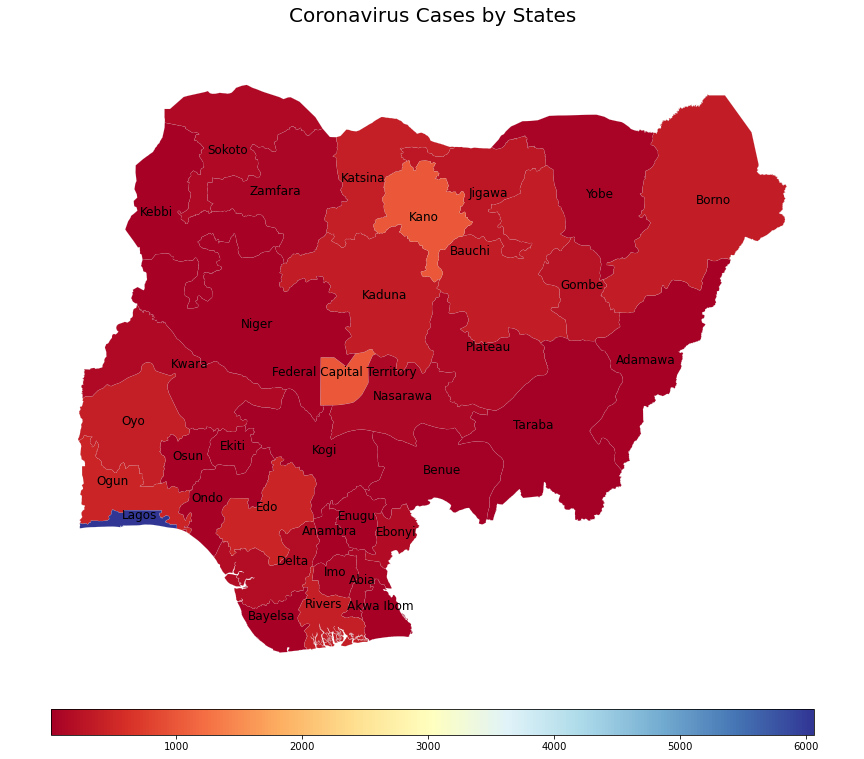

In [31]:
# Plot geomap for cases
visual(data, 'Cases', 'RdYlBu')

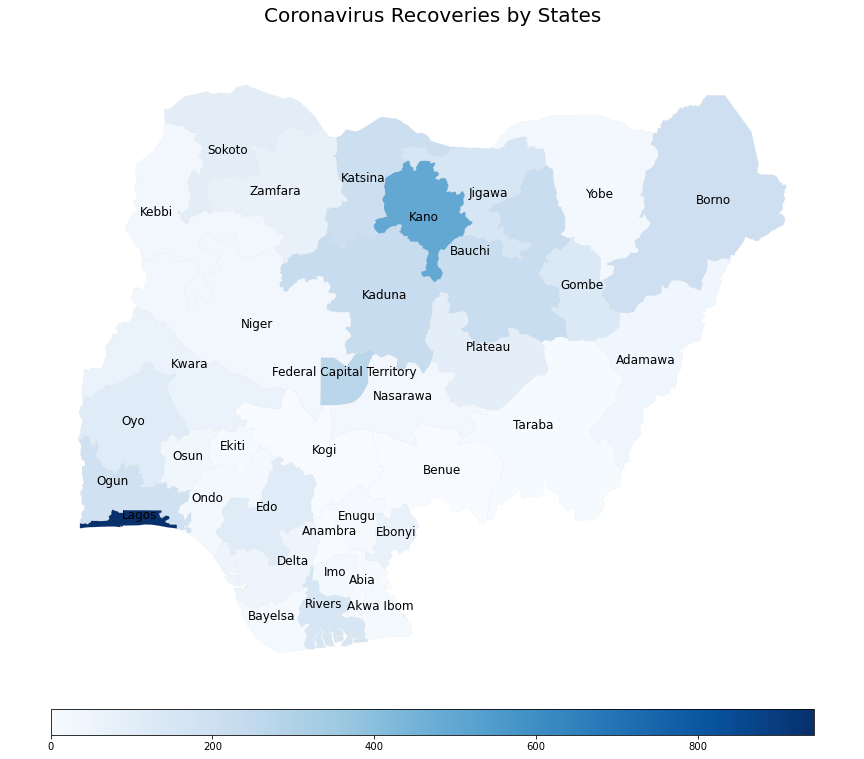

In [32]:
# Plot geomap for recoveries
visual(data, 'Recoveries', 'Blues')

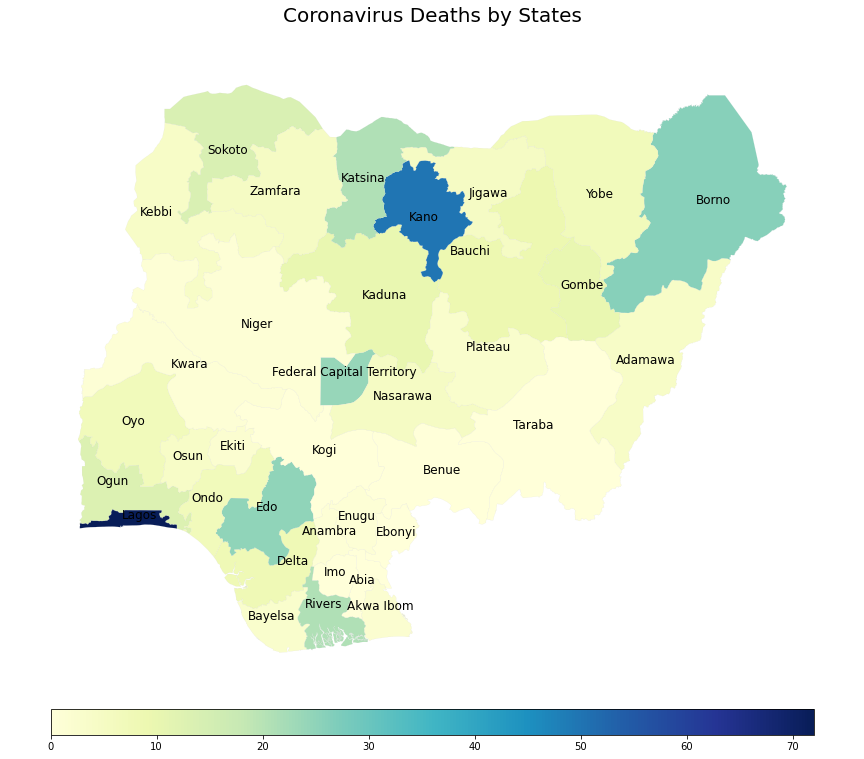

In [33]:
# Plot geomap for deaths
visual(data, 'Deaths', 'YlGnBu')